**Linear mixed modeling from DataCamp**

This will serve as some notes for the Hierarchical and Mixed Effect Models in R from DataCamp [link](https://learn.datacamp.com/courses/hierarchical-and-mixed-effects-models). The sections will correspond to the sections in the course.

# Overview and introduction to hierarchical and mixed models

In [30]:
library(tidyverse)
library(WWGbook)       # for data loading
library(lme4)
library(stats)
library(broom)
library(broom.mixed)
# in a newer version of broom, functionality was moved to broom.mixed package
# see https://stackoverflow.com/questions/64855115/tidy-function-gives-this-error-no-tidy-method-for-objects-of-class-lmermod-it

Course overview:

- Components for mixed-effect models (see how it can be applied to student test scores)
- Applying and interpreting linear mixed-effect models (e.g. regression)
- Generalized linear mixed-effect models
- Repeated measure models (e.g. time-series analysis)

What is a hierarchical model?

- Data can have several types of structure, including being nested within itself, making it "hierarchical". (Example: evaluating whether sitting or standing has an effect on engagement time but whether it's an iPhone or Samsung matters more.)

Why do we use a hierarchical model?

- Data nested within itself.
    - Example: Each student has their own test score but student performance can vary because of classroom-level factors, such as teacher quality, or school-level factors such as building quality. Hence, one might ask "Are students really independent from other students in the same classroom or school?" (Probably not.)
- Pool information across small sample sizes. (What if each classroom has a different number of students?)
    - Example: Maybe 5th grade has 30 students while 3rd grade only has 5. By chance, the 3rd grade test scores are more likely to have high or low outliers because of the law of large numbers. By treating classroomms as a "random-effect" within the model, we can pool shared information about means across the classrooms within the same school.
- Repeated observations across groups or individuals.
    - Example: What if we revisit the same group of students year-after-year? Here, the observations are *not* independent across years. A repeated-measures analysis is another example of a hierarchical models and allows us to correct for this (described in chapter 4).

Other names for hierarchical models

- Hierarchical models: nested models, multi-level models
- Regression framework
    - "Pool" information
    - "Random-effect" versus a "fixed-effect"
    - "Mixed-effect" (linear mixed-effect model; LMM)
    - Linear mixed-effect regression (lmer)
- Repeated sampling: getting the same measurements of individuals or groups over time
    - Repeated measures
    - Paired-tests
    
Example for learning: school test scores

Meta-data:
- Gain in math scores for individual students from K to first grade
- Part of a national-level assessment in US
- Subset of data from West, Welch, and Galecki

Student-level variables:
- Studentid: `childid`
- Math test-score gain: `mathgain`
- Math kindergarten score: `mathdind`
- Student's sex: `sex`
- Student's minority status: `minority`
    
At the end of the chapter, we'll fit a multi-level model to our data. We'll explore the data. The purpose of the coding exercise is to show that linear models don't always produce intuitive results and that it is necessary to add a new technique to your modeling toolbox.

The data contains classroom and school-level data.

Classoom-level variables:
- Classroom id: `classid`
- Teacher's math training: `mathprep`
- Teacher's math test knowledge test score: `mathknow`
- Teacher's years teaching: `yearstea`

School-level variables:
- School id: `schoolid`
- School's household poverty level: `housepov`
- School's socioeconomic status: `ses`



## Exploring data

In [2]:
attach(classroom)

In [3]:
head(classroom)

,sex,minority,mathkind,mathgain,ses,yearstea,mathknow,housepov,mathprep,classid,schoolid,childid
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,1,448,32,0.46,1,NA,0.082,2.00,160,1,1
2,0,1,460,109,-0.27,1,NA,0.082,2.00,160,1,2
3,1,1,511,56,-0.03,1,NA,0.082,2.00,160,1,3
4,0,1,449,83,-0.38,2,-0.11,0.082,3.25,217,1,4
5,0,1,425,53,-0.03,2,-0.11,0.082,3.25,217,1,5
6,1,1,450,65,0.76,2,-0.11,0.082,3.25,217,1,6


### Build a simple (linear) model firstm

Before using a hierarchical model, it's useful to plot and build a simple model. It provides comparison and troubleshooting is simpler with a linear model.

In this exercise, plot and model how math test score gains vary with SES across three levels without ccounting for hierarchical nature of data. Model data at the student level.

In [4]:
# Rename so that the same variables can be used as the DC lesson.
studentData <- classroom

`geom_smooth()` using formula 'y ~ x'




Call:
lm(formula = mathgain ~ housepov, data = studentData)

Residuals:
     Min       1Q   Median       3Q      Max 
-168.226  -22.222   -1.306   19.763  195.156 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   56.937      1.674   34.02   <2e-16 ***
housepov       3.531      7.515    0.47    0.639    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.63 on 1188 degrees of freedom
Multiple R-squared:  0.0001858,	Adjusted R-squared:  -0.0006558 
F-statistic: 0.2208 on 1 and 1188 DF,  p-value: 0.6385


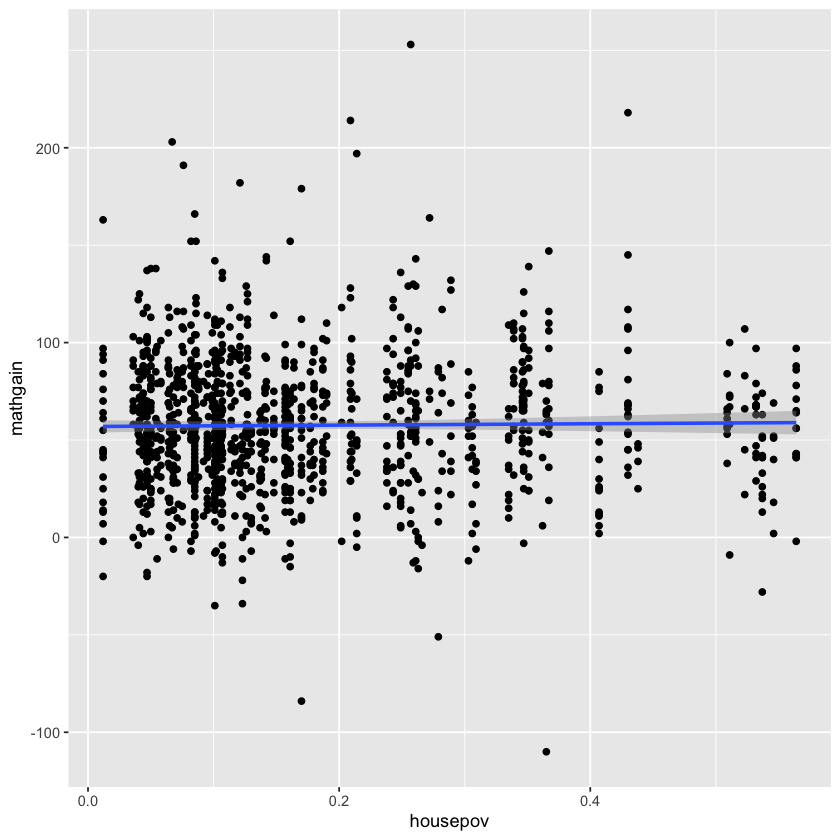

In [5]:
# Plot the data
ggplot(data = studentData, aes(x = housepov, y = mathgain)) +
    geom_point() +
    geom_smooth(method = 'lm')

# Fit a linear model
summary(lm(mathgain ~ housepov , data =  studentData))

### Explore multiple-levels

The simple model above assumed students were independent of each other. However, students learn within classrooms and schools. Aggregating scores by classroom and school can account for lack of student independence. Aggregation methods are important, especially for unequal group sizes.

Here, we'll use summary means for school and classroom. Another method would be to take 2 means (1st student by class, 2nd by class by school).

Aggregated datasets for both class and school are needed.

First build an aggregated classData set from the studentData, using the classid. For each class, take the mean of the students in the class.

In [6]:
head(studentData)

,sex,minority,mathkind,mathgain,ses,yearstea,mathknow,housepov,mathprep,classid,schoolid,childid
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,1,448,32,0.46,1,NA,0.082,2.00,160,1,1
2,0,1,460,109,-0.27,1,NA,0.082,2.00,160,1,2
3,1,1,511,56,-0.03,1,NA,0.082,2.00,160,1,3
4,0,1,449,83,-0.38,2,-0.11,0.082,3.25,217,1,4
5,0,1,425,53,-0.03,2,-0.11,0.082,3.25,217,1,5
6,1,1,450,65,0.76,2,-0.11,0.082,3.25,217,1,6


In [7]:
classData <- studentData %>%
                group_by(classid, schoolid) %>%
                summarize(housepov = mean(housepov, na.rm=T),
                          mathgain = mean(mathgain, na.rm=T))

head(classData)

`summarise()` has grouped output by 'classid'. You can override using the `.groups` argument.



classid,schoolid,housepov,mathgain
<int>,<int>,<dbl>,<dbl>
1,61,0.335,47.80000
2,34,0.303,65.66667
3,56,0.040,15.66667
4,67,0.339,91.50000
5,15,0.121,182.00000
6,21,0.187,39.40000


The, build an aggregated schoolData set from the classData, using the studentid. For each school, take the mean of the classes in the school. 

In [8]:
# schoolData <- classData %>%
#                group_by(schoolid) %>%
#                summarize(housepov = mean(housepov, na.rm=T),
#                          mathgain = mean(mathgain, na.rm=T))

# head(schoolData)

schoolData <- studentData %>%
                group_by(schoolid) %>%
                summarize(housepov = mean(housepov, na.rm=T),
                          mathgain = mean(mathgain, na.rm=T))

head(schoolData)

schoolid,housepov,mathgain
<int>,<dbl>,<dbl>
1,0.082,59.63636
2,0.082,65.00000
3,0.086,88.85714
4,0.365,35.16667
5,0.511,60.16667
6,0.044,78.66667


`geom_smooth()` using formula 'y ~ x'



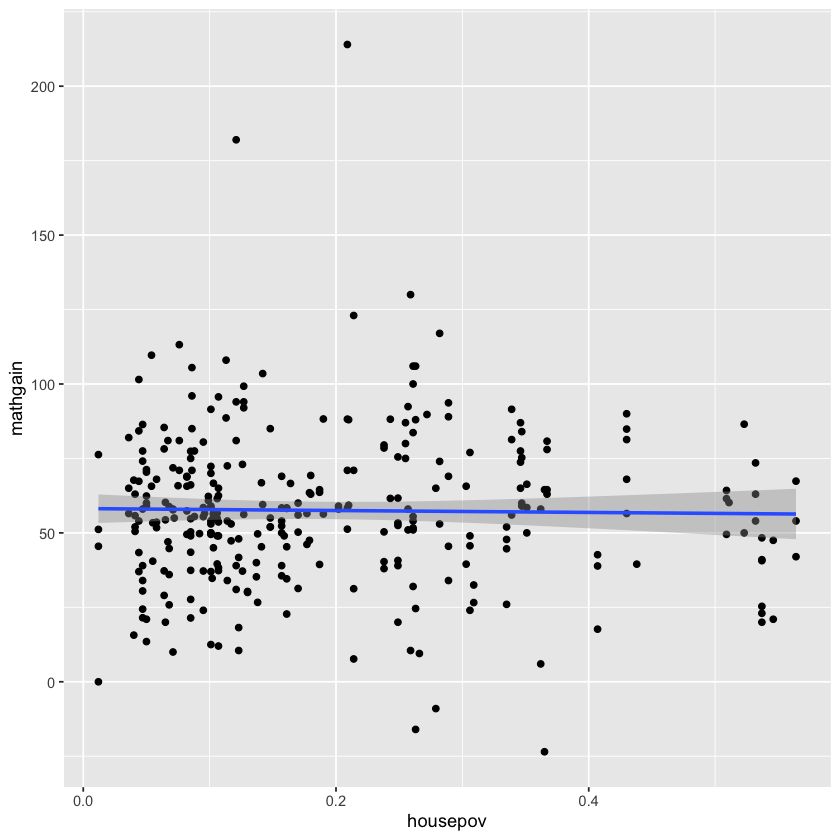

In [9]:
# First, plot the housepov and mathgain at the classroom-level from the classData data.frame
ggplot(data = classData, aes(x = housepov, y = mathgain)) +
    geom_point() +
    geom_smooth(method = 'lm')

`geom_smooth()` using formula 'y ~ x'



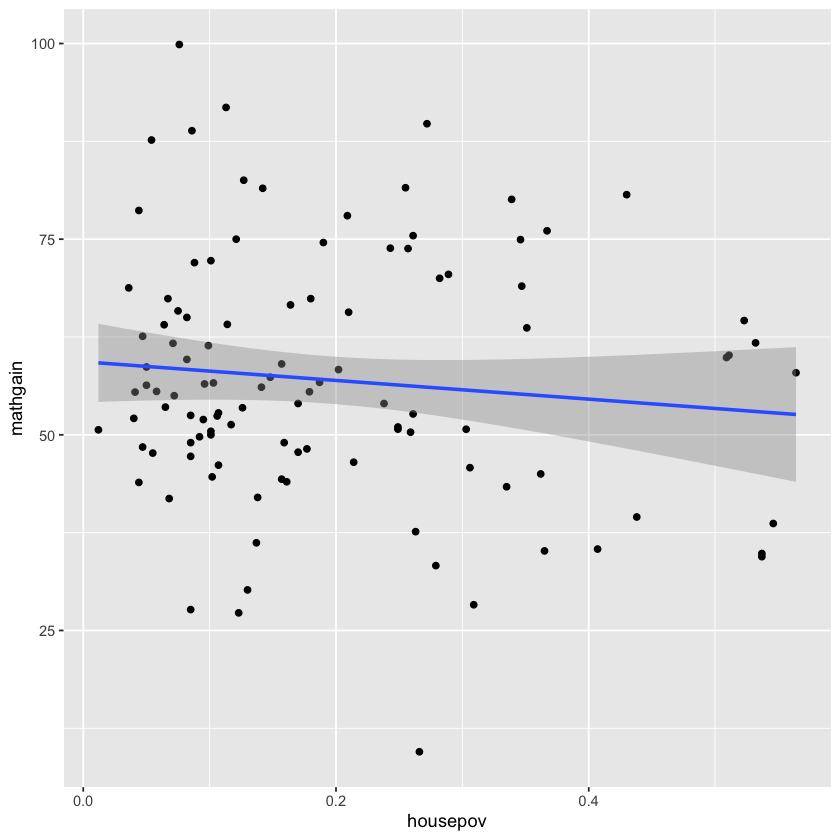

In [10]:
# Second, plot the housepov and mathgain at the school-level from the schoolData data.frame
ggplot(data = schoolData, aes(x = housepov, y = mathgain)) +
    geom_point() +
    geom_smooth(method = 'lm')

Now, compare your linear regression results from the previous expercise to the two new models

In [11]:
summary(lm(mathgain ~ housepov, data = studentData)) ## student-level data
summary(lm(mathgain ~ housepov, data = classData)) ## class-level data
summary(lm(mathgain ~ housepov, data = schoolData)) ## school-level data


Call:
lm(formula = mathgain ~ housepov, data = studentData)

Residuals:
     Min       1Q   Median       3Q      Max 
-168.226  -22.222   -1.306   19.763  195.156 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   56.937      1.674   34.02   <2e-16 ***
housepov       3.531      7.515    0.47    0.639    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.63 on 1188 degrees of freedom
Multiple R-squared:  0.0001858,	Adjusted R-squared:  -0.0006558 
F-statistic: 0.2208 on 1 and 1188 DF,  p-value: 0.6385



Call:
lm(formula = mathgain ~ housepov, data = classData)

Residuals:
    Min      1Q  Median      3Q     Max 
-80.479 -14.444  -1.447  13.151 156.516 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   58.160      2.542  22.879   <2e-16 ***
housepov      -3.236     10.835  -0.299    0.765    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 26.14 on 310 degrees of freedom
Multiple R-squared:  0.0002876,	Adjusted R-squared:  -0.002937 
F-statistic: 0.08918 on 1 and 310 DF,  p-value: 0.7654



Call:
lm(formula = mathgain ~ housepov, data = schoolData)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.660  -9.947  -2.494   9.546  41.445 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   59.338      2.624  22.616   <2e-16 ***
housepov     -11.948     10.987  -1.087    0.279    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.8 on 105 degrees of freedom
Multiple R-squared:  0.01114,	Adjusted R-squared:  0.00172 
F-statistic: 1.183 on 1 and 105 DF,  p-value: 0.2793


**The significance for association between `mathgain` and `housepov` looks higher the more the data is aggregated.**

Although none of the estimates differs significantly from zero, *arbitrary* data aggregation can be avoided using hierarchical models.

## Parts of a regression

Reviewing basics of linear regression. Models can be shown different ways.

$y = \beta_0 + \beta_2x_2 + \beta_3x_3 + \epsilon$  (one group serves as reference)
<br>
$y = \beta_1 + \beta_2x_2 + \beta_3x_3 + \epsilon$  (means for each determined separately, also this is ANOVA))

In R:

`lm(formula, data)`
<br>
`lm(y ~ x, data = myData)`
<br>
`anova(lm(y ~ x, data = myData))`

This is how linear models are built for *discrete* predictor variables.

--------

Discrete predictors -> $\beta$ represents corresponding *intercepts*
<br>
Continuous predictors -> $\beta$ represents corresponding *slopes*
--------

*Continuous* predictor variables are similar (slopes).

$y$ ~ $\beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \epsilon$ 

Multiple regression caveats:
- Assumes independence of predictor variables. Deviations can be bad.
- Previous statements, means you need to say "Corrected for"...
- Simpson's paradox can be bad if you're missing some groups
- Only linear relationships
- Interactions may be important

Multiple regression in R tips. Needs some formatting for syntax.

- `lm(y ~ x -1)` estimates an intercept for each x rather than just relative to first group
- Numeric versus factors (need to specify)
- Scaling parameters and slopes (consistent units, be mindful if using time)
- Shortcut for notating an interaction: `lm(y ~ x1 * x2)`
- When plotting a regression line in a scatter plot, use `geom_abline`, extracting the intercept and slope instead of `geom_smooth`. It will translate well to later implementations.


### Coefficients as *intercepts* for discrete variables

Intercepts are an important part of regression models, including hierarchical models. Without other coefficients, a single intercept is the global mean of the data. Similarly, multiple intercepts allow you to estimate the mean for each group as long as other coefficients are not estimated.

Using simulated data, you will see how means and intercepts are identical under situations without other coefficients. First, plot the raw data. Second, build a linear model and then plot the results. Extracting and plotting linear models results in R requires data wrangling, a topic covered in other R courses, so the code to do this is included here.

```
# Plot the means of your data, predictor is your x-variable, response is your y-variable, and intDemo is your data.frame
ggIntDemo <- 
	ggplot(intDemo, aes(x = predictor, y = response) ) +
    geom_point() +
    theme_minimal() + stat_summary(fun = "mean", color = "red",
                                   size = 3, geom = "point") +
    xlab("Intercept groups")
print(ggIntDemo)

# Fit a linear model to your data where response is "predicted by"(~) predictor
intModel <- lm(predictor ~ response - 1 , data = intDemo)
summary(intModel)

# Extract out the coefficient estimates using tidy
intCoefPlot <- tidy(intModel)

# Remove the word "predictor" for the coefficients
intCoefPlot$term <- factor(gsub("predictor", "", intCoefPlot$term))

# Add the new points to the previous plot
ggIntDemo + geom_point(data = intCoefPlot,
                           aes(x = term, y = estimate),
                           position = position_dodge(width = 0.4),
                           color = 'blue', size = 8, alpha = 0.25)
```

### Coefficients as *slopes* for continuous variables

During the previous exercise, you used multiple intercepts to model the expected values for discrete groups. During this exercise, you will include continuous predictor variables, slopes, in the model.

Building models for data science is often an iterative process, requiring both visualizing and modeling data.

In this exercise, you will:

- Plot the data and build a model that assumes all the data come from one group with the same linear response to the predictor variable x. This model has one slope and one intercept estimate.

- Challenge the above assumption. What happens if we model each group with its own intercept?

- Go a step farther. What happens if we model each group as having its own slope and intercept?

Assuming all data comes from the same group.
```
# plot the raw data using ggplot2
ggplot(data = multIntDemo, aes(x = x, y = response)) + 
	geom_point() + stat_smooth(method = 'lm')

# build a linear model with response predicted by x 
lm(response ~ x - 1, data = multIntDemo)                 # Put in -1
```

Plot shows data that appears to be monotonically increasing.

LM output:

```
Coefficients:
    x  
5.984 
```

Plotting with each group as its own color and as a group as another predictor variable.
```
# plot the data with each group as its own color
ggplot(data = multIntDemo, aes(x = x, y = response, color = group)) + 
	geom_point()

# build a linear model with response predicted by group and x
lm(response ~ group + x - 1, data = multIntDemo)    # Answer is the same, group + x - 1 or x + group - 1  
```

Plot shows data shows groups behave differently with increasing x.

LM output:

```
Coefficients:
groupa  groupb  groupc       x  
 2.784   8.746  12.892   3.270  
 ```

Include an interaction between group and x using group\*x with response as the response variable. This will estimate a slope and intercept for each group.

```
# plot the data using ggplot2 using a different color for each group
ggplot(data = multIntDemo, aes(x = x, y = response, color = group)) + 
	geom_point() + stat_smooth(method = 'lm')

# build a linear model with response predicted by x including an interaction with group 
lm(response ~ group*x - 1, data = multIntDemo)
```

Plot shows groups with different slopes. The interactions are also quite variable.

LM output:

```
Coefficients:
  groupa    groupb    groupc         x  groupb:x  groupc:x  
  1.7654    6.8709   15.7859    3.7793    0.4285   -1.9560  
```

Note: the console didn't like the -1 in the lm formula.

```
lm(formula = response ~ group * x, data = multIntDemo)

Coefficients:
(Intercept)       groupb       groupc            x     groupb:x     groupc:x  
     1.7654       5.1055      14.0205       3.7793       0.4285      -1.9560

```

## Random-effects in regressions

We've looked at slopes and intercepts. But what if a variable is nested within another distribution? Example: Students nested within classrooms and classrooms nested within schools.

A nested relationship is hierarchical in nature and it creates a multi-level model. Mathematically, this is called a *mapping from one distribution to another*. Practically, it's a way to pool or share information across replicates. Thus, outliers from groups with small sample sizes have less impact if we treat them as a random-effect.

This equation depicts a simple random effect.

| Equation |  Description |
| -- | -- |
| $y$ ~ $\beta_ix + \epsilon$          |  Depicts relationship to the data given a beta  |
|  $\beta$ ~ Normal($\mu, \sigma)$     |  Assumes beta is drawn from a normal distribution |

This is the algebraic representation.

Course will use `lme4` package but other packages exist because it's still an area of ongoing research. Here is some syntax.

```
library(lme4)
lmer(y ~ x (1|randomGroup), data = myData)              # to specify a random intercept
lmer(y ~ x (randomSlope|randomGroup), data = myData)    # to specify a random slope
```

Linear models in R estimate *fixed-effect* parameters. These parameters are considered to be fixed, or non-random values. 

In contrast, *random-effect* parameters assume data share a common error distribution. These parameters are considered to be *random* values drawn from a common error distribution. For situations with small amounts of data or outliers, random-effect models can produce different estimates.

The `lme4` package fits mixed-effect models (models with both fixed- and random-effects) with `lmer()`. `lmer()` uses formula, similar to `lm()`. But, random-effect intercepts use special syntax: `lmer(y ~ x + (1|randomEffect), data = myData)`.

Note: Unsure if `lmer` can do fixed effects only as a substitute for `lm`.


### Random-effect intercepts

Examine how response can be predicted by a fixed-effect slope variable, x, and a random intercept, group.

```
# Run model
outLmer <- lmer(response ~ x + (1|group), data = multIntDemo)

# Look at model outputs 
summary(outLmer)
tidy(outLmer)
```

Output:

```

# Look at model outputs 
summary(outLmer)
Linear mixed model fit by REML ['lmerMod']
Formula: response ~ x + (1 | group)
   Data: multIntDemo

REML criterion at convergence: 76.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.31526 -0.61183 -0.01542  0.45132  2.19076 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept)  7.981   2.825   
 Residual             10.715   3.273   
Number of obs: 15, groups:  group, 3

Fixed effects:
            Estimate Std. Error t value
(Intercept)   3.5559     2.1917   1.622
x             2.9730     0.5976   4.975

Correlation of Fixed Effects:
  (Intr)
x -0.545


tidy(outLmer)
# A tibble: 4 x 6
  effect   group    term            estimate std.error statistic
  <chr>    <chr>    <chr>              <dbl>     <dbl>     <dbl>
1 fixed    <NA>     (Intercept)         3.56     2.19       1.62
2 fixed    <NA>     x                   2.97     0.598      4.97
3 ran_pars group    sd__(Intercept)     2.83    NA         NA   
4 ran_pars Residual sd__Observation     3.27    NA         NA   
```


After fitting the model and examining the results, extract and plot the results. We provide this code because it uses advanced data wrangling. This data wrangling is required because random-effects are usually not plotted. Furthermore, ggplot2 does not include nice plot options for mixed-effect models. In this plot, notice how the dashed lines from random-effect slopes compare to the solid lines from the fixed-effect slopes.

```

# First, re-run the model to re-load it
outLmer <- lmer(response ~ x + (1|group), data = multIntDemo)

# Second, save the model predictions as a column to the original data.frame
multIntDemo$lmerPredict <- predict(outLmer)

# Third, plot the original data
ggmultIntgDemo2 <- 
		ggplot(multIntDemo, aes(x = x, y = response) ) +
        geom_point(aes(color = group))+
        theme_minimal() +
        scale_color_manual(values = c("blue", "black", "red")) +
        geom_abline(data = multIntDemo,
                    aes(intercept = intercept, slope = slope, color = group))

# Fourth, use the predicted values to plot the new outputs
ggmultIntgDemo2 +
	geom_line(data =  multIntDemo,
              aes(x = x, y = lmerPredict, color = group),
              linetype = 2)
              
```

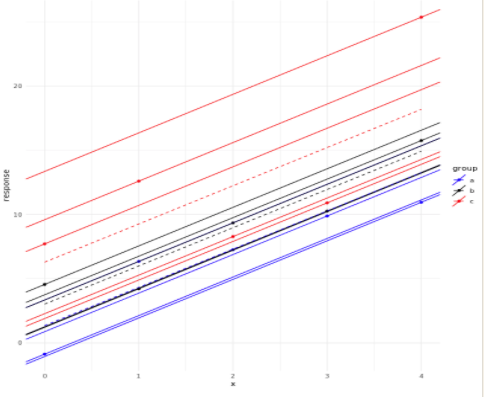

Notice how the dashed-lines from the random-effects model are drawn closer to each other compared to the solid lines. The dashed-lines also do not run through the data points. This is caused by the random-effect intercept and illustrates the difference between a random and fixed-effect model.

### Random-effect slopes

In the previous exercise, you saw how to code random-effect intercepts. During this exercise, you will see how to code random-effect slopes. With `lme4` syntax, `lmer()` uses `(countinuousPredictor|randomEffectGroup)` for a random effect slope. When `lme4` estimates a random-effect slope, it also estimates a random-effect intercept.



```
# Random-effect slopes
outLmer2 <- lmer(response ~ ( x |group), multIntDemo)
summary(outLmer2)
tidy(outLmer2)

```

Output

```
summary(outLmer2)
Linear mixed model fit by REML ['lmerMod']
Formula: response ~ (x | group)
   Data: multIntDemo

REML criterion at convergence: 69.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.56858 -0.54022 -0.06473  0.74979  1.28067 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 group    (Intercept) 274.115  16.556        
          x             6.100   2.470   -1.00
 Residual               2.467   1.571        
Number of obs: 15, groups:  group, 3

Fixed effects:
            Estimate Std. Error t value
(Intercept)   21.678      1.383   15.68
convergence code: 0
boundary (singular) fit: see ?isSingular
tidy(outLmer2)
# A tibble: 5 x 6
  effect   group    term               estimate std.error statistic
  <chr>    <chr>    <chr>                 <dbl>     <dbl>     <dbl>
1 fixed    <NA>     (Intercept)           21.7       1.38      15.7
2 ran_pars group    sd__(Intercept)       16.6      NA         NA  
3 ran_pars group    sd__x                  2.47     NA         NA  
4 ran_pars group    cor__(Intercept).x    -1        NA         NA  
5 ran_pars Residual sd__Observation        1.57     NA         NA 
```

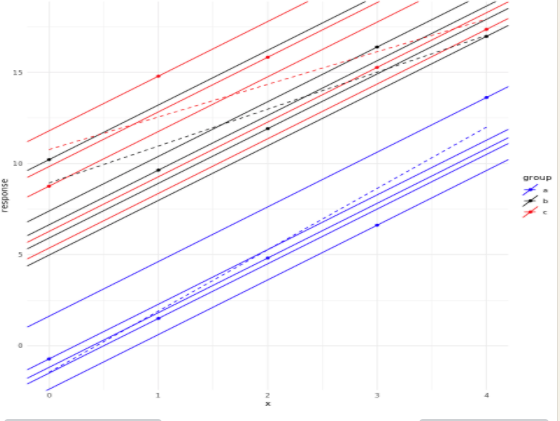

Notice how the random-effect slopes are no-longer parallel to the other slope estimates.

**Don't entirely understand this section**


### School data

1. Does the sex of a student impact their knowledge gain?
2. Does the teacher's training impact the gain and does the teacher's math knowlede impact the gain?

Plot the parameter estimates using ggplot2.


What predicts a student's increase in math skills (mathgain)? Does student's sex, teacher's preparation, mathprep, or teacher's knowledge, mathknow? Also, students learn within classrooms, classid, and schools, schoolid.

In [22]:
# This data can be run and plotted here.

# Mixed effect model
lmerModel <- lmer(mathgain ~ 
                  sex + mathprep + mathknow + 
                  (1|classid) + (1|schoolid), 
                  data = studentData, na.action = "na.omit",
                  REML = TRUE)

summary(lmerModel)

Linear mixed model fit by REML ['lmerMod']
Formula: mathgain ~ sex + mathprep + mathknow + (1 | classid) + (1 | schoolid)
   Data: studentData

REML criterion at convergence: 10677.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3203 -0.6146 -0.0294  0.5467  5.5331 

Random effects:
 Groups   Name        Variance Std.Dev.
 classid  (Intercept)  103.57  10.177  
 schoolid (Intercept)   85.44   9.244  
 Residual             1019.47  31.929  
Number of obs: 1081, groups:  classid, 285; schoolid, 105

Fixed effects:
            Estimate Std. Error t value
(Intercept)   52.250      3.838  13.613
sex           -1.526      2.041  -0.747
mathprep       2.426      1.298   1.869
mathknow       2.405      1.299   1.851

Correlation of Fixed Effects:
         (Intr) sex    mthprp
sex      -0.268              
mathprep -0.878  0.001       
mathknow -0.003  0.011  0.005

In this case, none of the predictors differed from zero.

Plotting the regression coefficients and their 95% confidence intervals can be another method to visualize and interpret them.

A positive coefficient indicates that as a coefficient increases, the expected response increases as well. Likewise, a negative coefficient indicates that as a coefficient increases, the expected response decreases. If the 95% CI does not include zero, the coefficient can be considered statistically significant.

In [31]:
library(broom.mixed)
tidy(lmerModel)

effect,group,term,estimate,std.error,statistic
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
fixed,NA,(Intercept),52.250122,3.838350,13.6126500
fixed,NA,sex,-1.525630,2.041257,-0.7473974
fixed,NA,mathprep,2.426310,1.298115,1.8691031
fixed,NA,mathknow,2.405429,1.299342,1.8512672
ran_pars,classid,sd__(Intercept),10.176981,NA,NA
ran_pars,schoolid,sd__(Intercept),9.243620,NA,NA
ran_pars,Residual,sd__Observation,31.929193,NA,NA


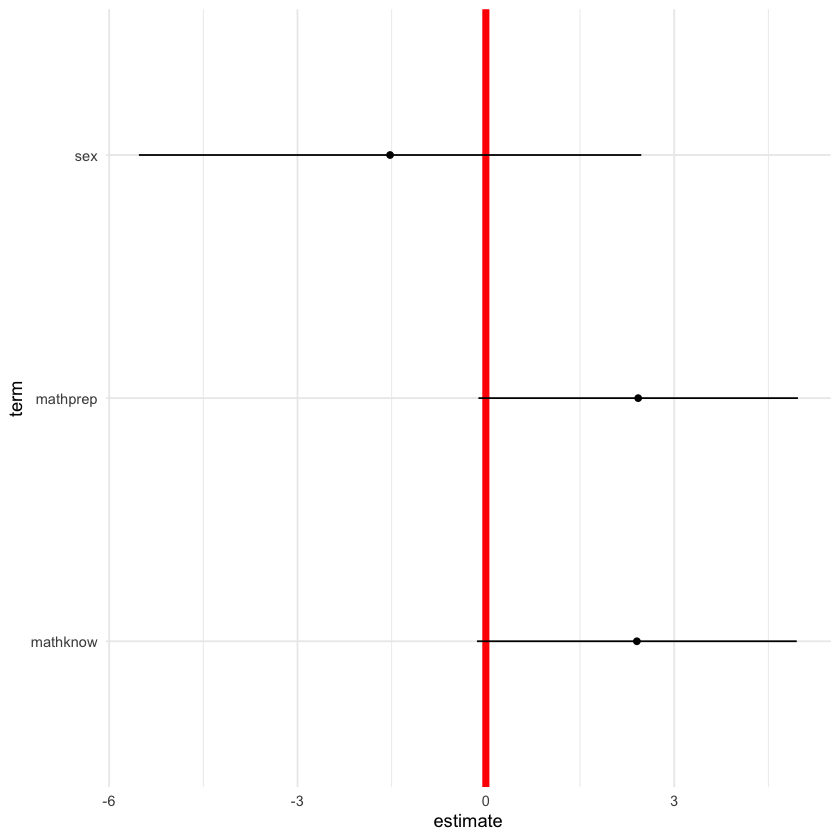

In [32]:
# Extract out the coefficents 
modelOutPlot <- tidy(lmerModel, conf.int = TRUE)

# Grab the coefficents of interest
modelOutPlot <- modelOutPlot[ modelOutPlot$effect =="fixed" &
                               modelOutPlot$term != "(Intercept)", ]

# plot the coefficients of interest
ggplot(modelOutPlot, aes(x = term, y = estimate,
                             ymin = conf.low,
                             ymax = conf.high)) +
	theme_minimal() +
	geom_hline(yintercept = 0.0, color = 'red', size = 2.0) +
	geom_point() +
	geom_linerange() + coord_flip()    

Although not significant, the teacher's math knowledge increases student gain (positive coefficient).

## Linear mixed effect model - birth rates data

In the video, you learned about the county-level birth rate data. Counties exist within states and perhaps states contribute to variability. During these exercises, you'll build a series of mixed-effects models using this data.

In this exercise, you'll build a hierarchical model with a global intercept (fixed-effect) and random-effect for state. You will then look at the summary() of the model and the plot() of the residuals. Like other types of regression analysis, examining residuals can help you see if anything is wrong with the model.

With lmer(), there are two methods for doing this: y ~ 1 + (1 | randomEffect) or the shortcut, y ~ (1 | randomEffect). Use the shortcut in this exercise so that your answer passes the DataCamp test.

When building mixed-effect models, starting with simple models such as the global intercept model can check to see if problems exist with either the data or code. A *global intercept* assumes a single intercept can describe all of the variability in the data. One way to view a global intercept is that you cannot do any better modeling that data than to only model mean without including any other predictor variables.

### Starting with only a global intercept

Writing model syntax

```
# Build a lmer with State as a random effect.
birthRateStateModel <- lmer(BirthRate ~ (1|State), data = countyBirthsData)
# Look at the model's summary and the residuals. 
summary(birthRateStateModel)
plot(birthRateStateModel)

```

Output:

```
Linear mixed model fit by REML ['lmerMod']
Formula: BirthRate ~ (1 | State)
   Data: countyBirthsData

REML criterion at convergence: 2411

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7957 -0.6056 -0.1063  0.5211  5.5948 

Random effects:
 Groups   Name        Variance Std.Dev.
 State    (Intercept) 1.899    1.378   
 Residual             3.256    1.804   
Number of obs: 578, groups:  State, 50

Fixed effects:
            Estimate Std. Error t value
(Intercept)  12.3362     0.2216   55.67
plot(birthRateStateModel)
```

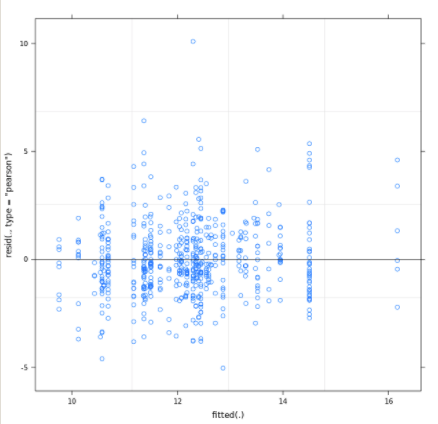

```
# Plot the predicted values from the model on top of the plot shown during the video.
countyBirthsData$birthPredictState <-  predict(birthRateStateModel, countyBirthsData)
ggplot() + 
    theme_minimal() +
    geom_point(data = countyBirthsData,
               aes(x = TotalPopulation, y = BirthRate)) + 
    geom_point(data = countyBirthsData,
               aes(x = TotalPopulation, y = birthPredictState),
               color = 'blue', alpha = 0.5) 
```

![LMM_dc_lmer4.png](attachment:LMM_dc_lmer4.png)

Notice how the outliers have been drawn closer to the center.

### Including a fixed effect

During the previous exercise, you built a model with only a global intercept. Usually, hierarchical models include predictor variables of interest.

The county-level birth data includes the average age of the mother, AverageAgeofMother. Perhaps this explains a county's birth rate.

In this case, the formula in R "knows" AverageAgeofMother is numeric and will treat the corresponding coefficient as a slope.

Build a hierarchical model with countyBirthsData, which has been loaded for you, and include a fixed-effect. Does the average age of the mother at birth predict the birth rate?

```
# Include the AverageAgeofMother as a fixed effect within the lmer and state as a random effect
ageMotherModel <- lmer(BirthRate ~ AverageAgeofMother + (1 | State),
                       countyBirthsData)
summary(ageMotherModel)
```

Output:

```
Linear mixed model fit by REML ['lmerMod']
Formula: BirthRate ~ AverageAgeofMother + (1 | State)
   Data: countyBirthsData

REML criterion at convergence: 2347.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9602 -0.6086 -0.1042  0.5144  5.2686 

Random effects:
 Groups   Name        Variance Std.Dev.
 State    (Intercept) 1.562    1.250   
 Residual             2.920    1.709   
Number of obs: 578, groups:  State, 50

Fixed effects:
                   Estimate Std. Error t value
(Intercept)        27.57033    1.81801  15.165
AverageAgeofMother -0.53549    0.06349  -8.434

Correlation of Fixed Effects:
            (Intr)
AvrgAgfMthr -0.994
```


Looking at the regression coefficient AverageAgeofMother, The estimate is negative, suggesting counties with older mothers have lower birth rates.

### Random-effect slopes

In the previous exercise, you estimated random-effect intercepts for each state. This allowed you to account for each state having its own intercept. During this exercise, you will estimate a random-effect slope for each state. For example, perhaps the log(total population of each county), `LogTotalPop`, changes the birth rate of a county AND varies by state.

Recall from the video, a random-effect `slope` may be estimated for each group using `(slope | group)` syntax with `lmer()`.

During this exercise, fit a mixed-effects model estimating the effect of the mother's average age while accounting for state and total population as random-effects.

How do the outputs from this model compare to the previous model you built?

```
# Include the AverageAgeofMother as fixed-effect and State as a random-effect
model_A <- lmer(BirthRate ~ AverageAgeofMother + (1|State), countyBirthsData)
tidy(model_A)

# Include the AverageAgeofMother as fixed-effect and LogTotalPop and State as random-effects
model_B <- lmer(BirthRate ~ AverageAgeofMother + (LogTotalPop|State), countyBirthsData)
tidy(model_B)

```

Output:

```

tidy(model_A)
# A tibble: 4 x 6
  effect   group    term               estimate std.error statistic
  <chr>    <chr>    <chr>                 <dbl>     <dbl>     <dbl>
1 fixed    <NA>     (Intercept)          27.6      1.82       15.2 
2 fixed    <NA>     AverageAgeofMother   -0.535    0.0635     -8.43
3 ran_pars State    sd__(Intercept)       1.25    NA          NA   
4 ran_pars Residual sd__Observation       1.71    NA          NA   
# Include the AverageAgeofMother as fixed-effect and LogTotalPop and State as random-effects
model_B <- lmer(BirthRate ~ AverageAgeofMother + (LogTotalPop|State), countyBirthsData)
Warning message: Model failed to converge with max|grad| = 0.00397397 (tol = 0.002, component 1)
tidy(model_B)
# A tibble: 6 x 6
  effect   group    term                         estimate std.error statistic
  <chr>    <chr>    <chr>                           <dbl>     <dbl>     <dbl>
1 fixed    <NA>     (Intercept)                    34.6      1.81        19.1
2 fixed    <NA>     AverageAgeofMother             -0.756    0.0620     -12.2
3 ran_pars State    sd__(Intercept)                13.5     NA           NA  
4 ran_pars State    sd__LogTotalPop                 2.26    NA           NA  
5 ran_pars State    cor__(Intercept).LogTotalPop   -0.997   NA           NA  
6 ran_pars Residual sd__Observation                 1.53    NA           NA  
```

How do the outputs from this model compare to the previous model you built?

Confidence of coefficient estimate is stronger.

### Uncorrelated random-effect slope

In the previous exercise, you use lme4's' default setting and assumed slopes and intercepts within each group were correlated for the random-effect estimates. However, this assumption may not always be valid or we may want to simplify the model if we are having trouble numerically fitting the model.

Building a model with uncorrelated random-effects is one method for potentially simplifying the model. Furthermore, lmer() models can be hard to fit and checking model outputs can be a useful step when debugging your model. Alternatively, you may have subject matter expertise and want to assume the random-effects are not correlated.

To fit a model with an uncorrelated random-effect slope, use || rather than | with lmer() syntax.

The second model you build in the previous exercise, model_B has been loaded for you. Compare the outputs of model_C to the old outputs from model_B.

The lme4 lmer [vignette](https://cran.r-project.org/web/packages/lme4/vignettes/lmer.pdf) includes a section on uncorrelated random-effects.

```
# Include AverageAgeofMother as fixed-effect and LogTotalPop and State as uncorrelated random-effects
model_C <- lmer(BirthRate ~ AverageAgeofMother + (LogTotalPop || State), 
                       countyBirthsData)
# Compare outputs of both models 
summary(model_B)
summary(model_C)
```
Output:

```
# Compare outputs of both models 
summary(model_B)
Linear mixed model fit by REML ['lmerMod']
Formula: BirthRate ~ AverageAgeofMother + (LogTotalPop | State)
   Data: countyBirthsData

REML criterion at convergence: 2276.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7040 -0.5714 -0.1073  0.4427  5.7292 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 State    (Intercept) 181.604  13.476        
          LogTotalPop   5.104   2.259   -1.00
 Residual               2.334   1.528        
Number of obs: 578, groups:  State, 50

Fixed effects:
                   Estimate Std. Error t value
(Intercept)        34.57563    1.80648   19.14
AverageAgeofMother -0.75561    0.06202  -12.18

Correlation of Fixed Effects:
            (Intr)
AvrgAgfMthr -0.994
convergence code: 0
Model failed to converge with max|grad| = 0.00397397 (tol = 0.002, component 1)
summary(model_C)
Linear mixed model fit by REML ['lmerMod']
Formula: BirthRate ~ AverageAgeofMother + ((1 | State) + (0 + LogTotalPop |  
    State))
   Data: countyBirthsData

REML criterion at convergence: 2347.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9602 -0.6086 -0.1042  0.5144  5.2686 

Random effects:
 Groups   Name        Variance Std.Dev.
 State    (Intercept) 1.562    1.250   
 State.1  LogTotalPop 0.000    0.000   
 Residual             2.920    1.709   
Number of obs: 578, groups:  State, 50

Fixed effects:
                   Estimate Std. Error t value
(Intercept)        27.57033    1.81801  15.165
AverageAgeofMother -0.53549    0.06349  -8.434

Correlation of Fixed Effects:
            (Intr)
AvrgAgfMthr -0.994
convergence code: 0
boundary (singular) fit: see ?isSingular
```

Fitting model_C gave a singular warning message. In this case, the more complex model is required. The results from model_B provide insight into why. Specifically, look at the summary of model_B. Which statement is true?

The random effect correlation for LogTotalPop is -1.00.

### Fixed- and random-effect predictor

In the previous exercises, you fit mixed-effect models with different fixed- and random-effects.

Sometimes, a model can have the same predictor as both a fixed and random-effect. For example, perhaps you are interested in estimating the average effect the age of a mother at birth (AverageAgeofMother). Including the predictor as fixed-effect allows you to estimate the effect of a mother's age across all locations. Including the predictor as a random-effect allows you to simultaneously account (or correct) for different slope estimates among states.

Construct a lmer() using AverageAgeofMother as a fixed-effect and AverageAgeofMother as a random-effect nested within State to predict BirthRate with the countyBirthsData. Make sure the fixed-effect goes before the random-effects in the formula.

```
# Construct a lmer() 
out <- lmer(BirthRate ~ AverageAgeofMother + (AverageAgeofMother | State),
                       countyBirthsData)

# Look at the summary
summary(out)

# Output:

Linear mixed model fit by REML ['lmerMod']
Formula: BirthRate ~ AverageAgeofMother + (AverageAgeofMother | State)
   Data: countyBirthsData

REML criterion at convergence: 2337.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8402 -0.5965 -0.1132  0.5233  5.1817 

Random effects:
 Groups   Name               Variance Std.Dev. Corr 
 State    (Intercept)        78.33144 8.8505        
          AverageAgeofMother  0.08433 0.2904   -0.99
 Residual                     2.80345 1.6744        
Number of obs: 578, groups:  State, 50

Fixed effects:
                   Estimate Std. Error t value
(Intercept)        27.21961    2.41010  11.294
AverageAgeofMother -0.52344    0.08293  -6.312

Correlation of Fixed Effects:
            (Intr)
AvrgAgfMthr -0.997
convergence code: 0
Model failed to converge with max|grad| = 0.0133555 (tol = 0.002, component 1)
```

# Build up intuition using SII data
See Galecki book

Start with early chapters using LM.
What if you assume LM?
Then fixed effects with correlated errors?
Then mixed effects?

In [35]:
dim(classroom)

[1] 1190   12

In [38]:
# to use the syntax from Galecki book
SIIdata <- classroom

## Exploratory data analysis

Look at the missing values.

In [39]:
sapply(SIIdata, FUN = function(x) any(is.na(x)))

sex minority mathkind mathgain      ses yearstea mathknow housepov 
   FALSE    FALSE    FALSE    FALSE    FALSE    FALSE     TRUE    FALSE 
mathprep  classid schoolid  childid 
   FALSE    FALSE    FALSE    FALSE

In [40]:
sum(as.numeric(is.na(SIIdata$mathknow)))

[1] 109

In [41]:
(schlN <- xtabs(~schoolid, SIIdata)) # Number of pupils per school

schoolid
  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
 11  10  14   6   6  12  14  16   6  18  31  27   9  15  13   6   9   4  11  12 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
 17   4   5   8   7  15  21  10   8   3  22   9  22   7  11   8  11   9  12   7 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
  9  18   4  17   5  13  10   6   8  12   4   9   8  10  13  10   8   5   4  13 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 
 11  13   3  10   9   8  12  16   5  19  27  11  10   3  15  27  24  15  12   7 
 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 
  9  19  12  14  20   7  10   6   4   3  16   9  21  15   5   8   6   2  19  13 
101 102 103 104 105 106 107 
 16  11   8   6  10   2  10 

In [42]:
range(schlN)

[1]  2 31

In [43]:
# distribution of number of pupils per school
xtabs(~schlN)

schlN
 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24 27 31 
 2  4  6  5  8  5  9  9 10  7  7  6  3  5  4  2  2  3  1  2  2  1  3  1 

In [44]:
# Compute the mean value of pupils’ math scores for each school

(mthgM <- by(cbind(mathgain, mathkind), schoolid, colMeans))

INDICES: 1
 mathgain  mathkind 
 59.63636 458.36364 
------------------------------------------------------------ 
INDICES: 2
mathgain mathkind 
    65.0    487.9 
------------------------------------------------------------ 
INDICES: 3
 mathgain  mathkind 
 88.85714 469.14286 
------------------------------------------------------------ 
INDICES: 4
 mathgain  mathkind 
 35.16667 462.66667 
------------------------------------------------------------ 
INDICES: 5
 mathgain  mathkind 
 60.16667 445.33333 
------------------------------------------------------------ 
INDICES: 6
 mathgain  mathkind 
 78.66667 457.08333 
------------------------------------------------------------ 
INDICES: 7
 mathgain  mathkind 
 57.35714 442.07143 
------------------------------------------------------------ 
INDICES: 8
mathgain mathkind 
 47.2500 498.6875 
------------------------------------------------------------ 
INDICES: 9
 mathgain  mathkind 
 34.83333 475.33333 
-----------------------------------

In [46]:
library(reshape)


Attaching package: ‘reshape’


The following object is masked from ‘package:Matrix’:

    expand


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:tidyr’:

    expand, smiths




In [48]:
idvars <- c("schoolid")
mvars <- c("classid", "childid")
dtm1 <- melt(SIIdata, id.vars = idvars, measure.vars = mvars)

names(cst1 <- cast(dtm1, fun.aggregate = function(el) length(unique(el))))

[1] "schoolid" "classid"  "childid"

In [49]:
names(cst1) <- c("schoolid", "clssn", "schlN")

# Consider Statistical Rethinking

Preface: installed rethinking package

## Test of rethinking package is on page 42 of the book but other code to run is before that.

In [55]:
# define grid
p_grid <- seq( from=0 , to=1 , length.out=20 )

# define prior
prior <- rep( 1 , 20 )

# compute likelihood at each value in grid likelihood <- dbinom( 6 , size=9 , prob=p_grid )
# compute product of likelihood and prior unstd.posterior <- likelihood * prior
# standardize the posterior, so it sums to 1 posterior <- unstd.posterior / sum(unstd.posterior)

prior <- ifelse( p_grid < 0.5 , 0 , 1 )
prior <- exp( -5*abs( p_grid - 0.5 ) )

In [56]:
# 

library(rethinking)

globe.qa <- quap(
    alist(
        W ~ dbinom( W+L ,p) , # binomial likelihood p ~ dunif(0,1) # uniform prior
    ), 
    data=list(W=6,L=3) )

# display summary of quadratic approximation
precis( globe.qa )

ERROR: Error in eval(flist[[i]]): argument is missing, with no default


# UCLA Stats resource

[link](https://stats.idre.ucla.edu/other/mult-pkg/introduction-to-linear-mixed-models/)

Generation of LMM understanding from a simple example.

In [94]:
# Set plot size
library(repr)
options(repr.plot.width=10, repr.plot.height=8)

In [79]:
df <- data.frame(predictor = c(1, 1.25, 1.5, 1.75, 1.9, 2.5,
                       3, 3.25, 3.5, 3.75, 3.9, 4.5,
                       5, 5.25, 5.5, 5.75, 5.9, 6.5,
                       7, 7.25, 7.5, 7.75, 7.9, 8.5), 
                 target = c(4, 3.5, 3.75, 3, 3.25, 2.5,
                       5, 4.5, 4.75, 4, 4.25, 3.5,
                       6, 5.5, 5.75, 5, 5.25, 4.5,
                       7, 6.5, 6.75, 6, 6.25, 5.5),
                 group = c("doc1", "doc1", "doc1", "doc1", "doc1", "doc1",
                           "doc2", "doc2", "doc2", "doc2", "doc2", "doc2",
                           "doc3", "doc3", "doc3", "doc3", "doc3", "doc3",
                           "doc4", "doc4", "doc4", "doc4", "doc4", "doc4"))

df

predictor,target,group
<dbl>,<dbl>,<chr>
1.00,4.00,doc1
1.25,3.50,doc1
1.50,3.75,doc1
1.75,3.00,doc1
1.90,3.25,doc1
2.50,2.50,doc1
3.00,5.00,doc2
3.25,4.50,doc2
3.50,4.75,doc2


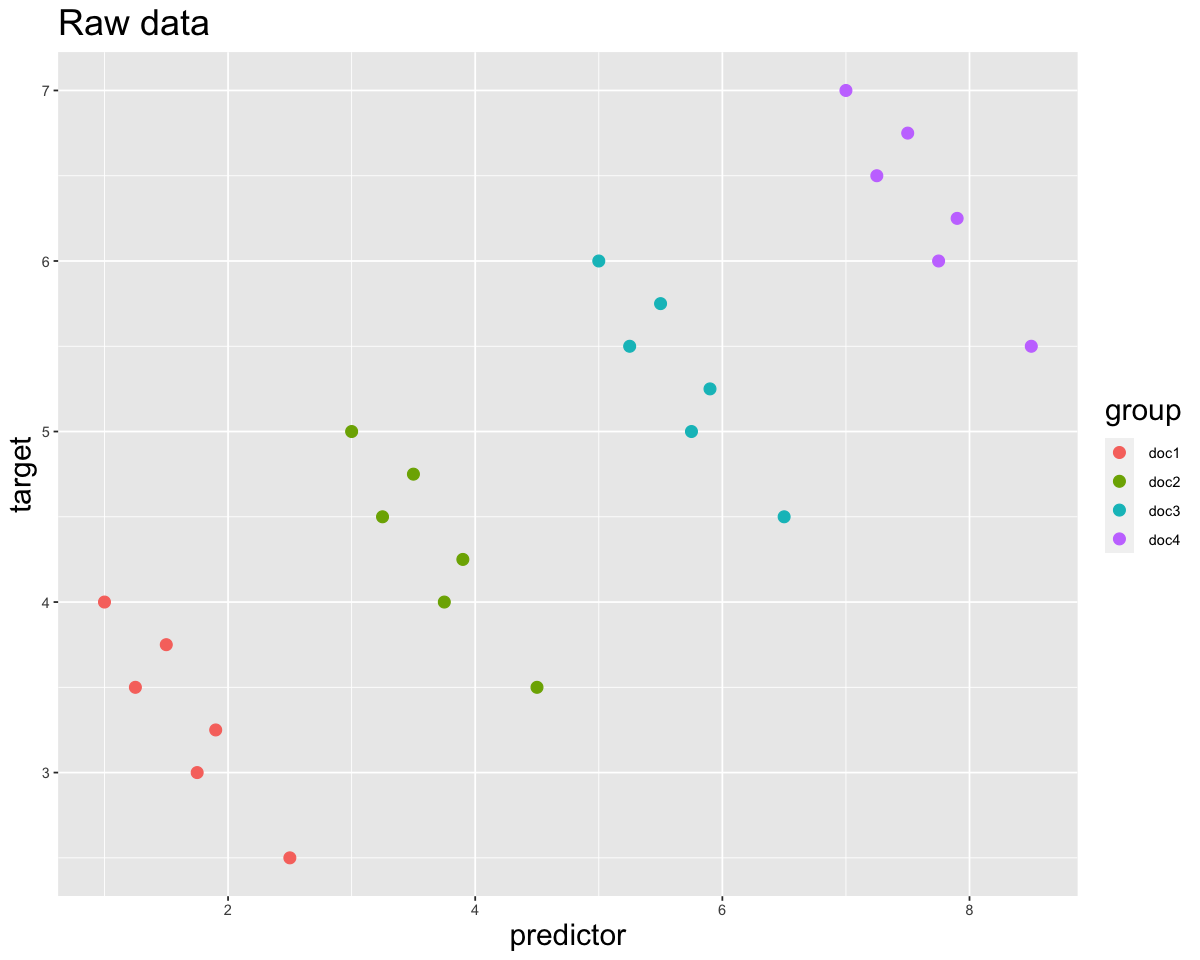

In [116]:
ggplot(df, aes(x = predictor, y = target)) +
    geom_point(size=3, aes(color=group)) +
    ggtitle("Raw data") +
    theme(title = element_text(size=18))

`geom_smooth()` using formula 'y ~ x'



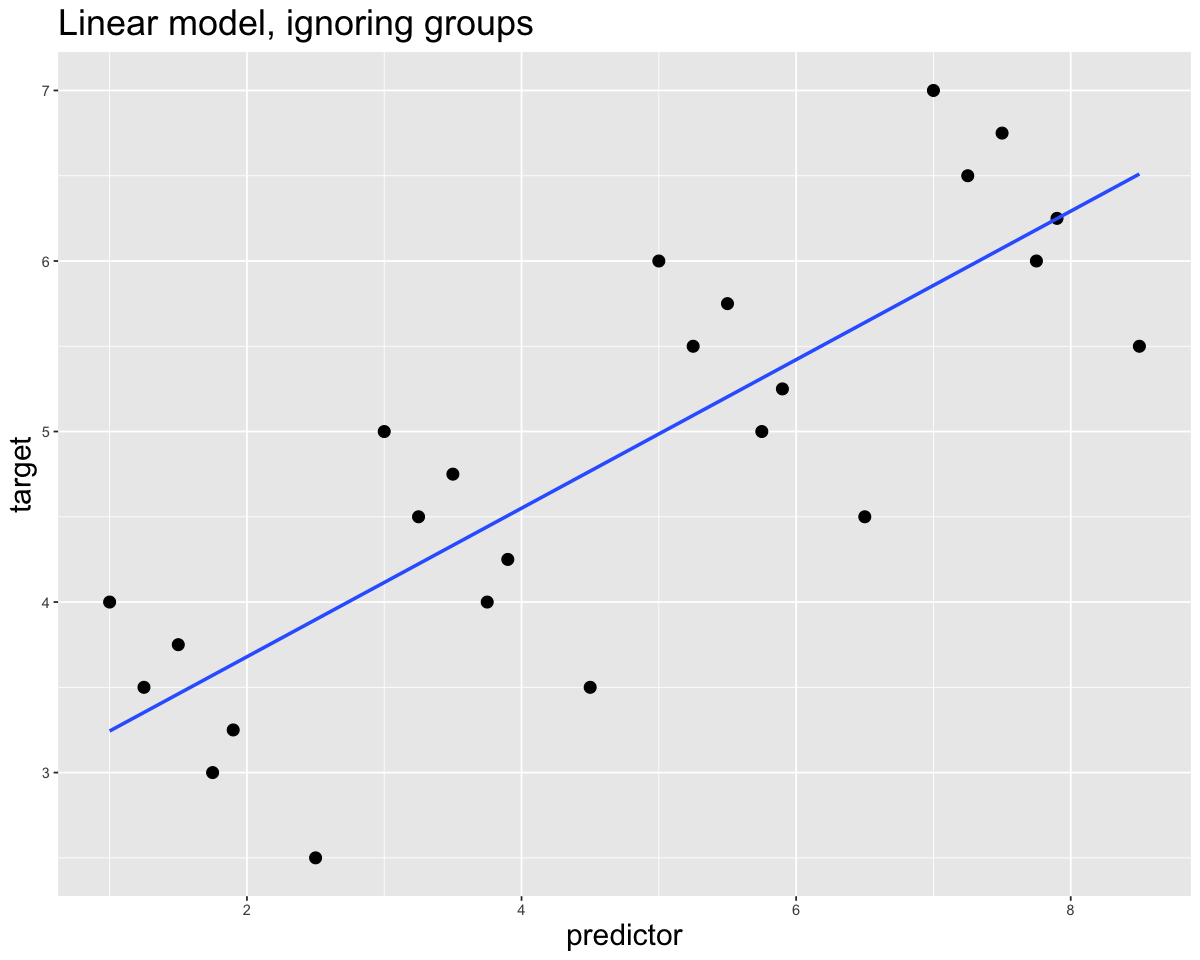

In [117]:
ggplot(df, aes(x = predictor, y = target)) +
    geom_point(size=3) +
    stat_smooth(method='lm', se=F) +
    ggtitle("Linear model, ignoring groups") +
    theme(title = element_text(size=18))

In [108]:
df_group <- df %>%
                group_by(group) %>%
                summarize(group_pred = mean(predictor),
                          group_targ = mean(target))
                          
df_group

,group,group_pred,group_targ
,<chr>,<dbl>,<dbl>
1,doc1,1.65,3.333333
2,doc2,3.65,4.333333
3,doc3,5.65,5.333333
4,doc4,7.65,6.333333


`geom_smooth()` using formula 'y ~ x'



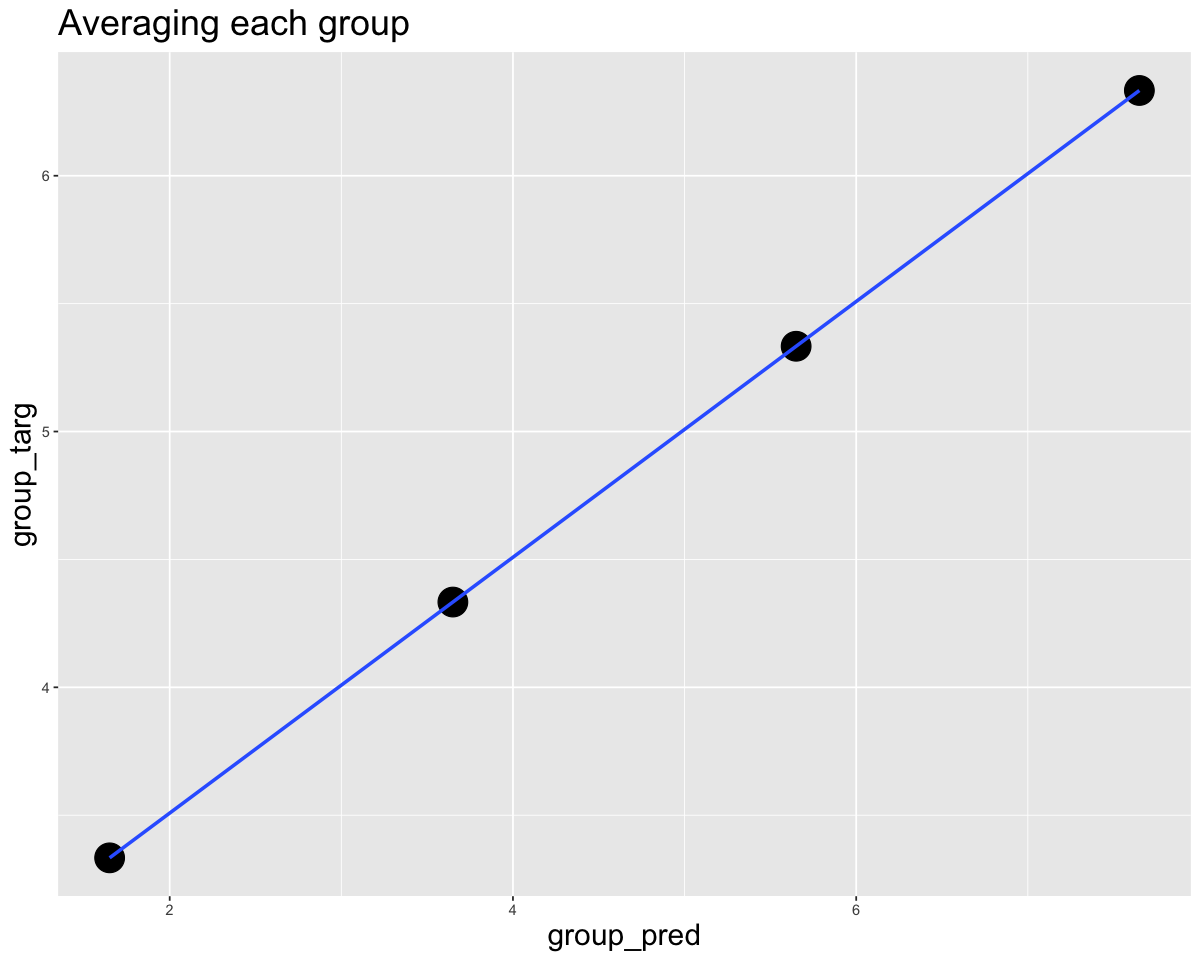

In [112]:
ggplot(df_group, aes(x = group_pred, y = group_targ)) +
    geom_point(size=8) +
    stat_smooth(method='lm', se=F) +
    ggtitle("Averaging each group") +
    theme(title = element_text(size=18))

In [ ]:
## Theory of linear mixed models

